In [1]:
import findspark
findspark.init('/home/hiba/spark-3.1.1-bin-hadoop3.2')
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession.builder.appName('Basics').getOrCreate()

In [2]:
from pyspark.sql.types import StructType,StringType,IntegerType,DoubleType

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [4]:
schema = StructType() \
      .add("country",StringType(),True) \
      .add("year",IntegerType(),True) \
      .add("sex",StringType(),True) \
      .add("age",StringType(),True) \
      .add("suicides_no",IntegerType(),True) \
      .add("population",IntegerType(),True) \
      .add("suicides/100k pop",DoubleType(),True) \
      .add("HDI_for_year",DoubleType(),True) \
      .add("gdp_for_year ($)",StringType(),True) \
      .add("gdp_per_capita ($)",IntegerType(),True) \
      .add("generation",StringType(),True)

In [5]:
data = spark.read \
    .options(header='True', inferSchema='True', delimiter=',')\
    .schema(schema) \
    .csv("master.csv")

In [6]:
data.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicides/100k pop: double (nullable = true)
 |-- HDI_for_year: double (nullable = true)
 |-- gdp_for_year ($): string (nullable = true)
 |-- gdp_per_capita ($): integer (nullable = true)
 |-- generation: string (nullable = true)



### Countries distribution

In [7]:
data.registerTempTable('data')
sqlContext = SQLContext(spark)

In [8]:
df1 = sqlContext\
    .sql("SELECT country, SUM(suicides_no) AS numberof_suicides \
    from data WHERE year=2015 GROUP BY country ORDER BY numberof_suicides desc limit 10")\
    .toPandas()

In [9]:
df1

,country,numberof_suicides
0,United States,44189
1,Russian Federation,25432
2,Japan,23092
3,Republic of Korea,13510
4,Brazil,11163
5,Germany,10088
6,Ukraine,7574
7,Mexico,6234
8,Poland,5420
9,United Kingdom,4910


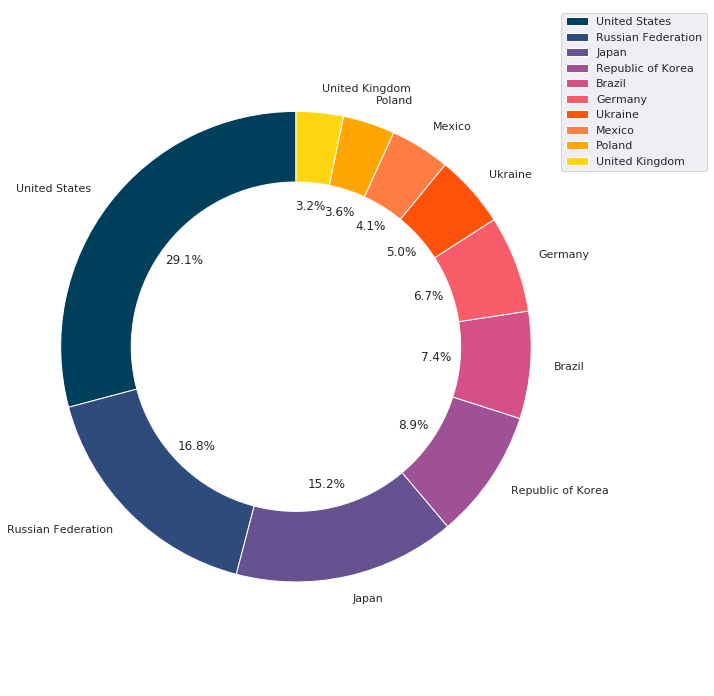

In [22]:
colors = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#f95d6a','#ff510a','#ff7c43','#ffa600','#ffd50f']
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(df1['numberof_suicides'], labels=df1.country,\
        autopct='%1.1f%%', startangle=90, colors=colors)

plt.legend(bbox_to_anchor = (1, 1))
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()
fig.savefig('pie_chart.png', dpi=100)

In [11]:
df_world = sqlContext\
    .sql("SELECT country, SUM(suicides_no) AS numberof_suicides from data WHERE year=2014 GROUP BY country")\
    .toPandas()
df_world

,country,numberof_suicides
0,Paraguay,379
1,Sweden,1148
2,Republic of Korea,13834
3,Singapore,355
4,Turkey,1617
...,...,...
73,Colombia,2126
74,Hungary,1925
75,Mauritius,120
76,United Kingdom,4788


## Suicide by gender and age

In [12]:
by_gender = sqlContext\
    .sql("SELECT country, \
    SUM(suicides_no) AS total_suicides, \
    SUM(CASE WHEN sex='male' THEN suicides_no ELSE 0 END) AS male_suicides, \
    SUM(CASE WHEN sex='female' THEN suicides_no ELSE 0 END) AS female_suicides \
    from data WHERE year=2015 \
    GROUP BY country ORDER BY total_suicides desc limit 10")\
    .toPandas()

In [13]:
by_gender

,country,total_suicides,male_suicides,female_suicides
0,United States,44189,33990,10199
1,Russian Federation,25432,20861,4571
2,Japan,23092,16146,6946
3,Republic of Korea,13510,9556,3954
4,Brazil,11163,8766,2397
5,Germany,10088,7403,2685
6,Ukraine,7574,6148,1426
7,Mexico,6234,4986,1248
8,Poland,5420,4697,723
9,United Kingdom,4910,3732,1178


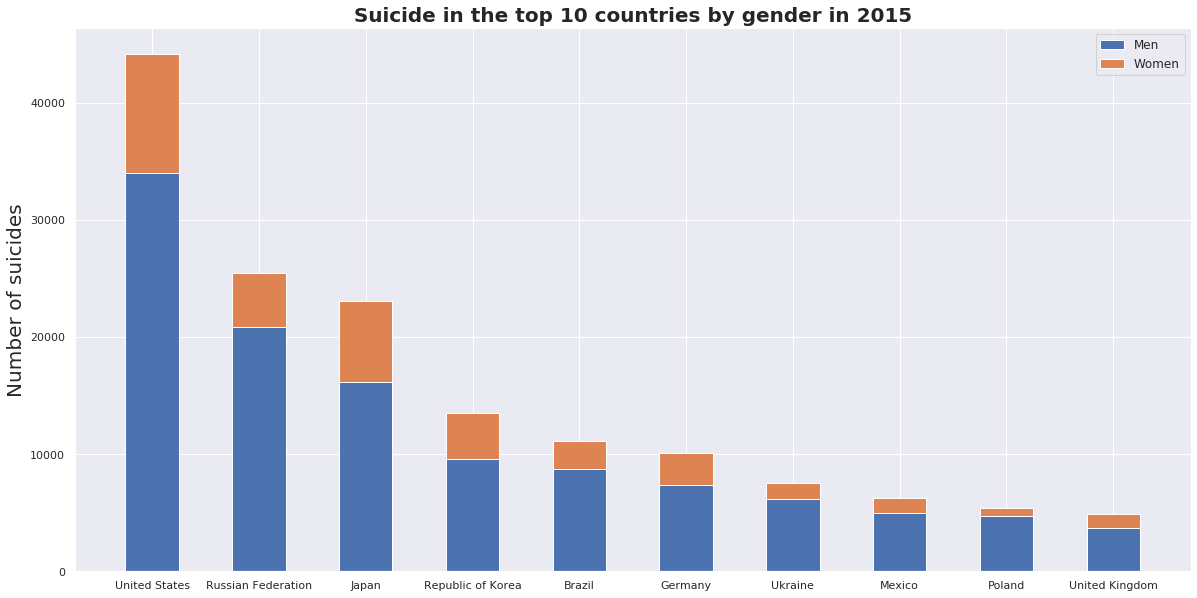

In [24]:
width = 0.5      

fig, ax = plt.subplots(figsize=(20,10))

ax.bar(by_gender['country'], by_gender['male_suicides'], width, label='Men')
ax.bar(by_gender['country'], by_gender['female_suicides'], width, bottom=by_gender['male_suicides'],
       label='Women')

ax.set_ylabel('Number of suicides', fontsize=20)
ax.set_title('Suicide in the top 10 countries by gender in 2015', fontsize=20, fontweight='bold')
ax.legend(fontsize='medium')

plt.show()
fig.savefig('hist.png',dpi=100)

# By age

In [15]:
by_age = sqlContext\
    .sql("SELECT country, \
    SUM(suicides_no) AS total, \
    SUM(CASE WHEN age='5-14 years' THEN suicides_no ELSE 0 END) AS kids, \
    SUM(CASE WHEN age='15-24 years' THEN suicides_no ELSE 0 END) AS teenagers, \
    SUM(CASE WHEN age='25-34 years' THEN suicides_no ELSE 0 END) AS young_adults, \
    SUM(CASE WHEN age='35-54 years' THEN suicides_no ELSE 0 END) AS adults, \
    SUM(CASE WHEN age='55-74 years' THEN suicides_no ELSE 0 END) AS old_people, \
    SUM(CASE WHEN age='75+ years' THEN suicides_no ELSE 0 END) AS eldery \
    from data WHERE year=2015 \
    GROUP BY country ORDER BY total desc limit 10")\
    .toPandas()

In [16]:
by_age

,country,total,kids,teenagers,young_adults,adults,old_people,eldery
0,United States,44189,413,5491,6947,15687,11940,3711
1,Russian Federation,25432,136,2306,5724,9289,5505,2472
2,Japan,23092,90,1499,2633,7531,7533,3806
3,Republic of Korea,13510,31,677,1560,5050,4113,2079
4,Brazil,11163,135,1786,2363,4148,2172,559
5,Germany,10088,19,512,914,3067,3212,2364
6,Ukraine,7574,52,624,1282,2608,2043,965
7,Mexico,6234,232,1831,1462,1863,672,174
8,Poland,5420,19,501,839,1921,1775,365
9,United Kingdom,4910,10,478,777,2052,1212,381


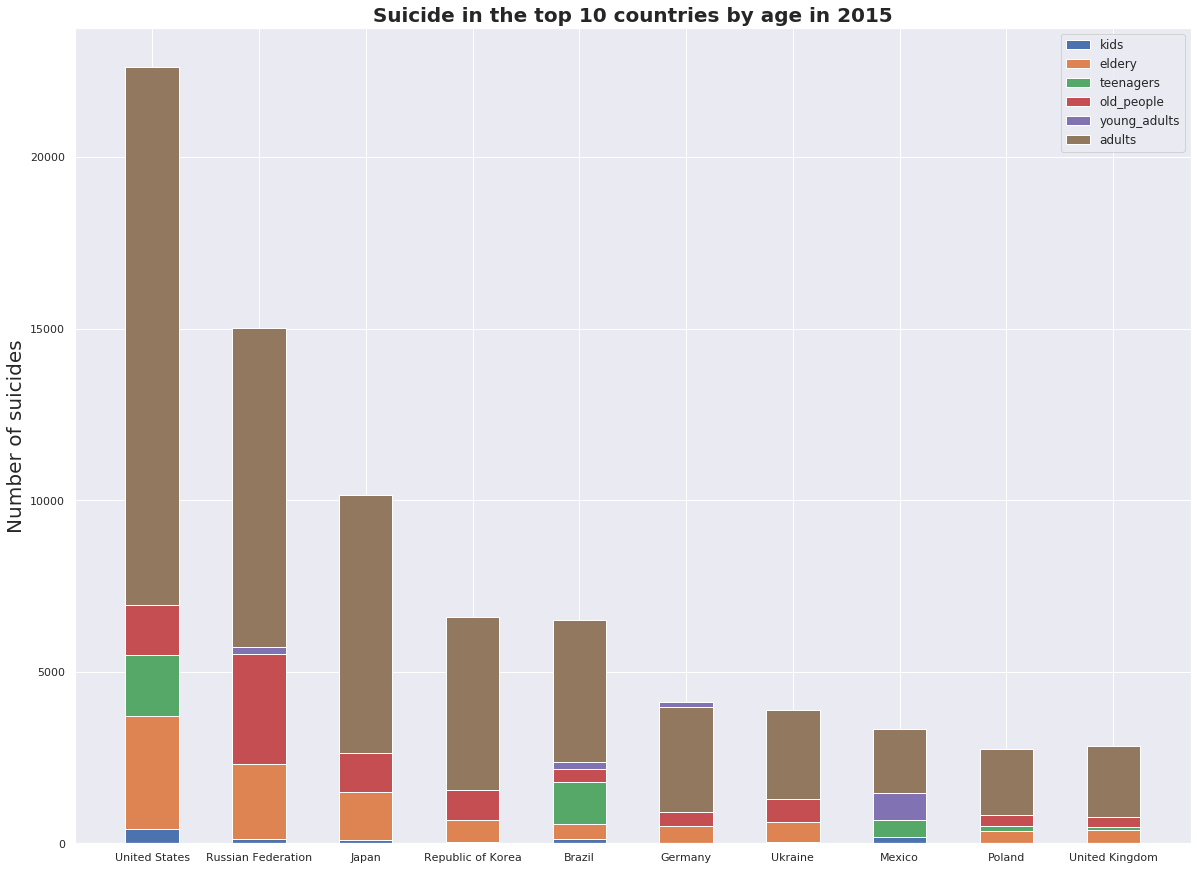

In [25]:
width = 0.5       

fig, ax = plt.subplots(figsize=(20,15))

ax.bar(by_age['country'], by_age['kids'], width, label='kids')
ax.bar(by_age['country'], by_age['eldery'], width, bottom=by_age['kids'],
       label='eldery')
ax.bar(by_age['country'], by_age['teenagers'], width, bottom=by_age['eldery'],
       label='teenagers')
ax.bar(by_age['country'], by_age['old_people'], width, bottom=by_age['teenagers'],
       label='old_people')
ax.bar(by_age['country'], by_age['young_adults'], width, bottom=by_age['old_people'],
       label='young_adults')
ax.bar(by_age['country'], by_age['adults'], width, bottom=by_age['young_adults'],
       label='adults')

ax.set_ylabel('Number of suicides', fontsize=20)
ax.set_title('Suicide in the top 10 countries by age in 2015', fontsize=20, fontweight='bold')
ax.legend(fontsize='medium')

plt.show()
fig.savefig('hist2.png',dpi=100)

In [18]:
dff1 = sqlContext\
    .sql("SELECT SUM(suicides_no) AS numberof_suicides from data WHERE year=2015 AND country='Turkey'")\
    .toPandas()
print(dff1.numberof_suicides[0])

1532
